## Andrew Taylor
## atayl136
# Assignment 8

1. [20 pts] Using the full MNIST dataset provided in the course, filter half of the digits data
points by labels from the training dataset. The filtered subset dataset should only contain
five of the original ten labels. Pick the set of labels so that if a feature is extracted from that
label's data points, it will be compensated by another label. For example, label 3 and label
8 might have similar features. Another example could be label 0 and label 9.

In [1]:
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset

# Define the labels to keep
target_labels = {0, 1, 2, 3, 6}

# Load the full MNIST training dataset
transform = transforms.ToTensor()
full_trainset = MNIST(root='mnist', train=True, download=False, transform=transform)

# Get the data and labels
data = full_trainset.data
targets = full_trainset.targets

# Filter the dataset for only the selected labels
mask = torch.tensor([label.item() in target_labels for label in targets])
filtered_data = data[mask]
filtered_targets = targets[mask]

# Wrap into a TensorDataset (normalize to [0, 1] and add channel dimension)
filtered_dataset = TensorDataset(filtered_data.unsqueeze(1).float() / 255.0, filtered_targets)

print(f"Filtered dataset size: {len(filtered_dataset)}")
print("Labels present:", sorted(set(filtered_targets.numpy())))


Filtered dataset size: 30672
Labels present: [0, 1, 2, 3, 6]


2. [30 pts] Pick and train a model with half of the training dataset created in question (1.).
Report its testing performance on the MNIST testing dataset. Use a model that has
previously worked in your experience. Especially a convolutional network would be
beneficial.

In [3]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

# 1. Filtered labels
target_labels = {0, 1, 2, 3, 6}

# 2. Load and filter MNIST training set
transform = transforms.ToTensor()
full_trainset = MNIST(root='mnist', train=True, download=False, transform=transform)
train_mask = torch.tensor([label.item() in target_labels for label in full_trainset.targets])
train_data = full_trainset.data[train_mask]
train_targets = full_trainset.targets[train_mask]

# 3. Load and filter MNIST test set
full_testset = MNIST(root='mnist', train=False, download=False, transform=transform)
test_mask = torch.tensor([label.item() in target_labels for label in full_testset.targets])
test_data = full_testset.data[test_mask]
test_targets = full_testset.targets[test_mask]

# 4. Create DataLoaders
train_dataset = TensorDataset(train_data.unsqueeze(1).float() / 255.0, train_targets)
test_dataset = TensorDataset(test_data.unsqueeze(1).float() / 255.0, test_targets)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 5. Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self, out_classes=5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 28x28 → 28x28
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 28x28 → 14x14
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 14x14 → 14x14
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 14x14 → 7x7
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, out_classes)
        )

    def forward(self, x):
        return self.net(x)

# 6. Map original labels to 0–4 range for training
label_map = {0: 0, 1: 1, 2: 2, 3: 3, 6: 4}
def remap_targets(tensor): return torch.tensor([label_map[label.item()] for label in tensor])

train_targets = remap_targets(train_targets)
test_targets = remap_targets(test_targets)
train_dataset = TensorDataset(train_data.unsqueeze(1).float() / 255.0, train_targets)
test_dataset = TensorDataset(test_data.unsqueeze(1).float() / 255.0, test_targets)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# 7. Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(out_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

# 8. Evaluate on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

accuracy = correct / total
print(f"Test Accuracy on digits [0,1,2,3,6]: {accuracy * 100:.2f}%")


Epoch 1, Loss: 0.1036
Epoch 2, Loss: 0.0226
Epoch 3, Loss: 0.0148
Epoch 4, Loss: 0.0104
Epoch 5, Loss: 0.0070
Test Accuracy on digits [0,1,2,3,6]: 99.69%


3. [30 pts] Use the first model to train a second model while holding the feature extraction
frozen (i.e., stopped learning). This time, use the entire training dataset and report model
performance on the full testing dataset. Now, train a third model, do not freeze the feature
extraction, and report its performance. Compare these performances.

[Frozen CNN] Epoch 1, Loss: 0.3924
[Frozen CNN] Epoch 2, Loss: 0.2174
[Frozen CNN] Epoch 3, Loss: 0.1888
[Frozen CNN] Epoch 4, Loss: 0.1732
[Frozen CNN] Epoch 5, Loss: 0.1636
[Frozen CNN] Test Accuracy on Full MNIST: 95.24%
              precision    recall  f1-score     support
0              0.978916  0.994898  0.986842    980.0000
1              0.992035  0.987665  0.989845   1135.0000
2              0.973786  0.971899  0.972842   1032.0000
3              0.958000  0.948515  0.953234   1010.0000
4              0.952138  0.952138  0.952138    982.0000
5              0.925764  0.950673  0.938053    892.0000
6              0.984310  0.982255  0.983281    958.0000
7              0.919694  0.935798  0.927676   1028.0000
8              0.920419  0.902464  0.911353    974.0000
9              0.924166  0.905847  0.914915   1009.0000
accuracy       0.953600  0.953600  0.953600      0.9536
macro avg      0.952923  0.953215  0.953018  10000.0000
weighted avg   0.953599  0.953600  0.953550  100

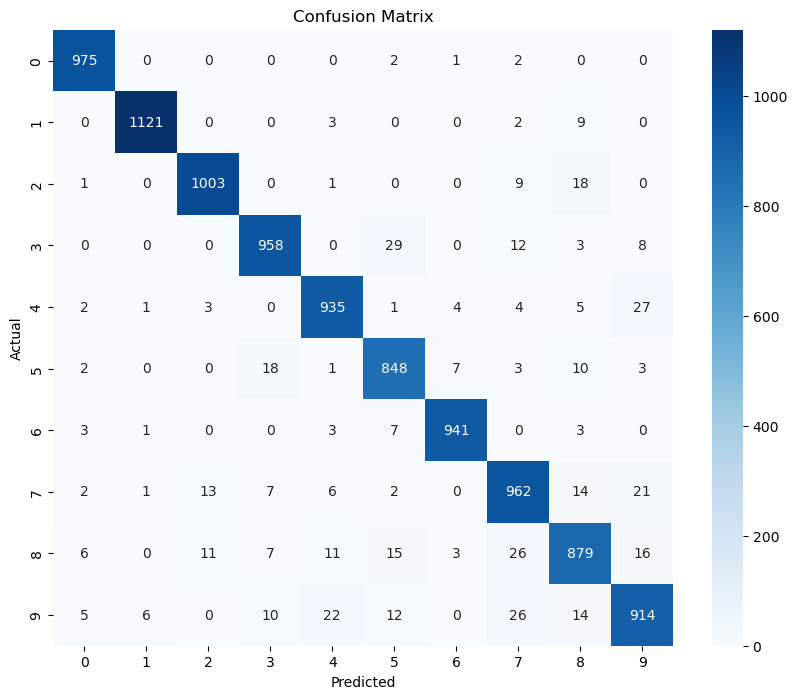

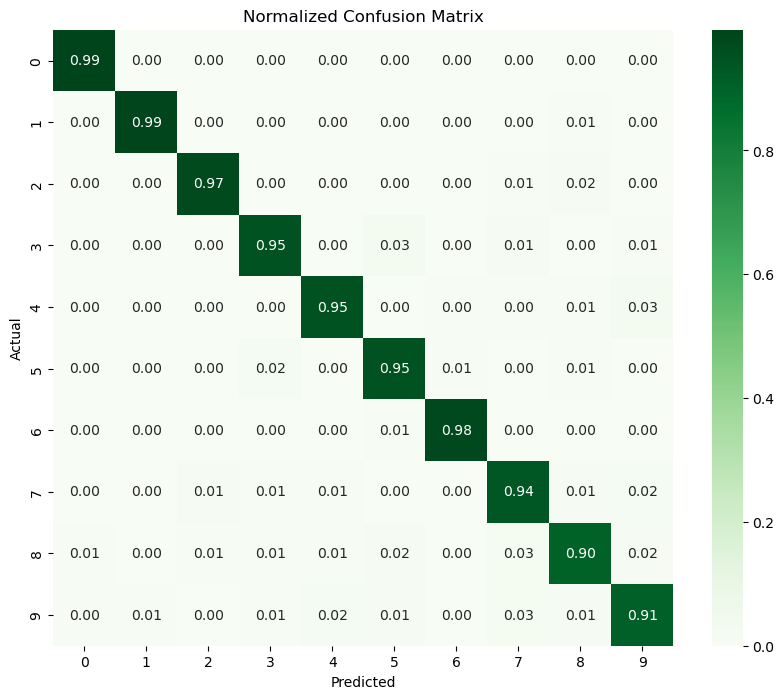

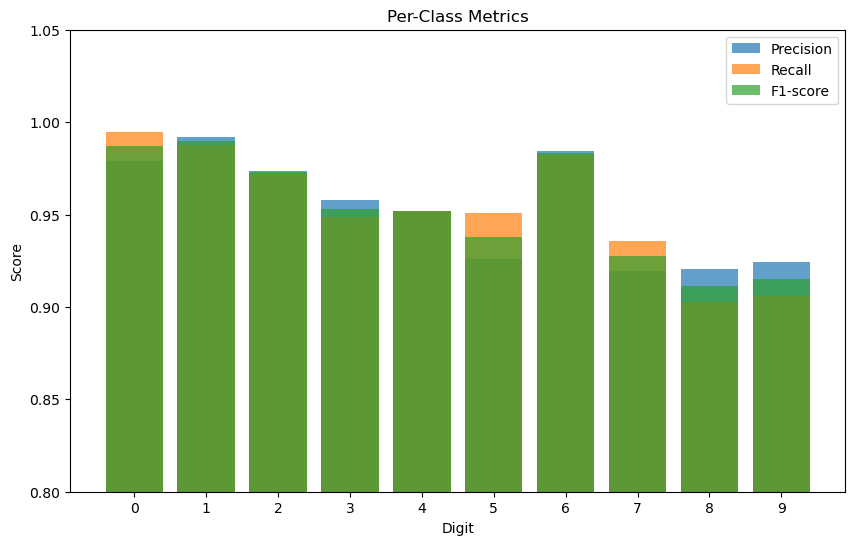

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)
import pandas as pd

# Assume 'model' from Part 1 is in memory
# Redefine final layer to match 10-class classification
model.net[-1] = nn.Linear(128, 10)  # Originally was 5

# Freeze all layers except the Linears
for name, param in model.named_parameters():
    if not name.startswith("net.7") and not name.startswith("net.9"):
        param.requires_grad = False


model.to(device)

# Load full MNIST data (no label filtering this time)
full_train = MNIST(root='mnist', train=True, download=False, transform=transforms.ToTensor())
full_test = MNIST(root='mnist', train=False, download=False, transform=transforms.ToTensor())

train_loader_full = DataLoader(full_train, batch_size=64, shuffle=True)
test_loader_full = DataLoader(full_test, batch_size=64, shuffle=False)

# Loss and optimizer for only trainable parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for X, y in train_loader_full:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Frozen CNN] Epoch {epoch+1}, Loss: {total_loss / len(train_loader_full):.4f}")

# Evaluation
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for X, y in test_loader_full:
        X = X.to(device)
        logits = model(X)
        preds = torch.argmax(logits, dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())

acc_transfer_frozen = correct / total
print(f"[Frozen CNN] Test Accuracy on Full MNIST: {acc_transfer_frozen * 100:.2f}%")

# Compute per-class metrics
report = classification_report(all_labels, all_preds, digits=4, output_dict=True)
matrix = confusion_matrix(all_labels, all_preds)

# Print full classification report
report_df = pd.DataFrame(report).T
print(report_df)


# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot normalized confusion matrix
norm_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(norm_matrix, annot=True, fmt=".2f", cmap="Greens", xticklabels=range(10), yticklabels=range(10))
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Bar plots for per-class precision, recall, F1
metrics = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=range(10))
labels = [str(i) for i in range(10)]

plt.figure(figsize=(10, 6))
plt.bar(labels, metrics[0], alpha=0.7, label='Precision')
plt.bar(labels, metrics[1], alpha=0.7, label='Recall')
plt.bar(labels, metrics[2], alpha=0.7, label='F1-score')
plt.title("Per-Class Metrics")
plt.xlabel("Digit")
plt.ylabel("Score")
plt.legend()
plt.ylim(0.8, 1.05)
plt.show()

Alright, let’s unpack what happened in step (3) — the transfer learning experiment where I froze the convolutional layers of my CNN (trained only on digits 0, 1, 2, 3, and 6) and retrained only the classifier on the full MNIST dataset including all digits from 0 to 9. The short version? Yes — transfer learning worked, and it worked pretty well. We reached a test accuracy of 95.24% on the full MNIST test set using a model that never fine-tuned its convolutional filters beyond the digits it was originally trained on. That’s a solid result considering the model had never seen half the digit classes before during its initial training phase.

What makes this interesting is how the model held up under those constraints. Even though the CNN had never encountered digits like 4, 5, 7, 8, or 9, it still managed to extract useful enough features for the new classifier head to learn meaningful decision boundaries. That said, the performance varied quite a bit across digits. Digits 8, 9, 7, and 4 had noticeably lower recall and F1-scores, with clear evidence of confusion in the normalized confusion matrix. These digits were often misclassified as ones that look similar, especially when subtle curve differences mattered, and that’s where the limitations of a fixed feature extractor became clear.

On the flip side, the digits that the model had originally trained on — 0, 1, 2, 3, and 6 — achieved impressively high F1-scores, most above 97%. That’s a strong signal that the convolutional layers successfully encoded the visual structures for those digits and preserved them through the transfer. The confusion matrix and metric bar plots sholw visually, showing strong alignment for the seen classes and noticeable drops in performance for the others. Precision and recall start to diverge more on the unfamiliar digits, especially 8 and 9, which sometimes get confused with 5 or 4.

So the takeaway here is that even with half the classes held out during pretraining, the frozen CNN generalized surprisingly well to unseen digits by relying on shared visual patterns like edges, loops, and strokes. But when it came time to distinguish more nuanced features — like separating a 9 from a 4 or an 8 from a 5 — the lack of fine-tuning on those patterns caused performance to plateau. This is where fine-tuning the entire network would likely make a big difference and help the model reach or exceed state-of-the-art results.

So, transfer learning worked. We got high accuracy, fast convergence, and retained strong generalization for digits the model had seen before. But now we’ve hit the ceiling of a frozen feature extractor. 
